In [2]:
import gc
import glob
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU
from keras.models import Sequential
from mlxtend.evaluate import accuracy
from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

In [3]:
#tf.random.set_seed(0)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [4]:
path_data = "data/data_palm_vein/NIR"

In [5]:
def load_img(path, xdim=128, ydim=128):
    label_names = []
    nmax = 6000
    X = []
    y = []
    count = 0
    #print("Loading images...")
    for dirname in tqdm_notebook(os.listdir(path), desc="Loading images..."):
        #print("dirname : ", dirname)
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        # print("data_path: " + data_path)
        files = glob.glob(data_path)
        #print("Count = ", count)
        if count > nmax: break
        for f1 in files:
            #print("files : ", f1)
            img = cv2.imread(f1)
            #img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img = cv2.imread(f1, 0)
            #img = cv2.resize(img, (xdim, ydim))
            X.append(np.array(img))
            y.append(dirname)
            count += 1
    print(count, ' images lues')
    X = np.array(X)
    y = np.array(y)
    gc.collect()
    return X, y, label_names

In [6]:
X, y, label_names = load_img(path_data)

print("y.shape = ", y.shape)
print("X.shape = ", X.shape)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]

6000  images lues
y.shape =  (6000,)
X.shape =  (6000, 128, 128)


In [7]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("Preprocessing data")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))

Preprocessing data
-----------------------------------------

X shape : (6000, 128, 128, 1)
-----------------------------------------
y shape : (6000, 501)



In [8]:
j = 4
print("X : ",X[j])
print("y : ", y[j])

X :  [[[0.50980392]
  [0.52156863]
  [0.5372549 ]
  ...
  [0.52156863]
  [0.51764706]
  [0.51372549]]

 [[0.5254902 ]
  [0.5254902 ]
  [0.52941176]
  ...
  [0.56078431]
  [0.55686275]
  [0.52156863]]

 [[0.52156863]
  [0.5254902 ]
  [0.52941176]
  ...
  [0.54117647]
  [0.55294118]
  [0.54901961]]

 ...

 [[0.48627451]
  [0.49019608]
  [0.50196078]
  ...
  [0.53333333]
  [0.52156863]
  [0.54509804]]

 [[0.49019608]
  [0.49019608]
  [0.49411765]
  ...
  [0.52941176]
  [0.51372549]
  [0.52941176]]

 [[0.50196078]
  [0.49411765]
  [0.48627451]
  ...
  [0.54509804]
  [0.51764706]
  [0.49803922]]]
y :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

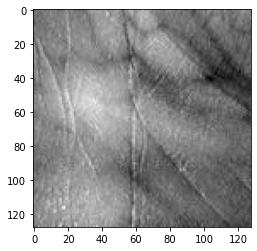

[[[0.55294118]
  [0.54509804]
  [0.55686275]
  ...
  [0.56862745]
  [0.57254902]
  [0.56470588]]

 [[0.54901961]
  [0.55686275]
  [0.56862745]
  ...
  [0.57647059]
  [0.58039216]
  [0.56862745]]

 [[0.54901961]
  [0.56862745]
  [0.56470588]
  ...
  [0.57647059]
  [0.57254902]
  [0.56862745]]

 ...

 [[0.55294118]
  [0.57647059]
  [0.57647059]
  ...
  [0.51372549]
  [0.51764706]
  [0.5254902 ]]

 [[0.56078431]
  [0.57254902]
  [0.57254902]
  ...
  [0.50980392]
  [0.51372549]
  [0.52156863]]

 [[0.56862745]
  [0.54509804]
  [0.56078431]
  ...
  [0.52156863]
  [0.51764706]
  [0.52941176]]]


In [9]:
j = 34
plt.imshow(X[j], cmap='gray')
#plt.imshow(X[j])
plt.show()
#print("\ny : \n",y[j])
print(X[j])

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Splitting data ...\n")
print("-----------------------------------------------------------------------------------------")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_test shape  : {}    |   y_test shape  : {}".format(X_test.shape, y_test.shape))
print("-----------------------------------------------------------------------------------------")
print("\nX_val shape   : {}    |   y_val shape   : {}".format(X_val.shape, y_val.shape))

Splitting data ...

-----------------------------------------------------------------------------------------

X_train shape : (4200, 128, 128, 1)    |   y_train shape : (4200, 501)
-----------------------------------------------------------------------------------------

X_test shape  : (900, 128, 128, 1)    |   y_test shape  : (900, 501)
-----------------------------------------------------------------------------------------

X_val shape   : (900, 128, 128, 1)    |   y_val shape   : (900, 501)


In [11]:
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(501, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)             

In [12]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
132/132 [==============================] - 13s 84ms/step - loss: 6.2238 - accuracy: 9.5238e-04
Epoch 2/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2189 - accuracy: 7.1429e-04
Epoch 3/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2186 - accuracy: 7.1429e-04
Epoch 4/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2184 - accuracy: 9.5238e-04
Epoch 5/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2182 - accuracy: 9.5238e-04
Epoch 6/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2179 - accuracy: 4.7619e-04
Epoch 7/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2177 - accuracy: 0.0014
Epoch 8/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2177 - accuracy: 9.5238e-04
Epoch 9/10
132/132 [==============================] - 10s 79ms/step - loss: 6.2173 - accuracy: 9.5238e-04
Epoch 10/10
132/132 [=============================

In [14]:
val = model.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))


Loss  : 621.85%
Score : 0.00%


In [15]:
def zfnet_model(input_shape, classes):
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(7, 7), strides=(2, 2), padding="valid", activation="relu",
                     kernel_initializer="uniform", input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Lambda(lambda x: tf.image.per_image_standardization(x)))

    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                     activation="relu", kernel_initializer="uniform"))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # model.add(Lambda(lambda x: tf.image.per_image_standardization(x)))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same",
                     kernel_initializer="uniform"))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same",
                     kernel_initializer="uniform"))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same",
                     activation="relu", kernel_initializer="uniform"))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=classes, activation="softmax"))

    print(model.summary())
    print("\n ================= ZFNET model ================= \n")
    # model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy',
    #               metrics=['accuracy', TopKCategoricalAccuracy(1)])
    model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001)
    # reduce_lr=0
    return model



In [16]:
Nombre_classes = len(label_names)
input_shape = (128, 128, 1)
model_zfnet = zfnet_model(input_shape, Nombre_classes)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 61, 61, 96)        4800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 256)       614656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 384)         885120    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)        

In [17]:
trained_modelzfnet = model_zfnet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

val = model_zfnet.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))


Epoch 1/3
132/132 [==============================] - 32s 229ms/step - loss: 6.2407 - accuracy: 7.1429e-04 - val_loss: 6.2165 - val_accuracy: 0.0011
Epoch 2/3
132/132 [==============================] - 30s 225ms/step - loss: 6.2195 - accuracy: 7.1429e-04 - val_loss: 6.2166 - val_accuracy: 0.0044
Epoch 3/3
132/132 [==============================] - 30s 230ms/step - loss: 6.2177 - accuracy: 0.0017 - val_loss: 6.2164 - val_accuracy: 0.0033

Loss  : 621.75%
Score : 0.00%


In [18]:
from keras.applications.resnet_v2 import ResNet152V2

def resnet_model_tf(input_shape=(128, 128, 1), nombre_classes=501):
    resnet = ResNet152V2(weights=None, include_top=False, input_shape=input_shape)
    resnet.trainable = False
    model = Sequential()
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nombre_classes, activation='softmax'))
    
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [19]:
model_resnet = resnet_model_tf()

trained_model_resnet = model_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4)

val1 = model_resnet.evaluate(X_test, y_test, verbose=0)

print("\nLoss  : %.2f%%" % (val1[0] * 100))
print("Score : %.2f%%" % (val1[1] * 100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 4, 4, 2048)        58325376  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_6 (Dense)              (None, 501)               513525    
Total params: 92,394,357
Trainable params: 34,068,981
Non-trainable params: 58,325,376
_________________________________________________________________
None
Epoch 1/4
132/132 [==============================] - 59s 421ms/step - loss: 6.2461 - accuracy: 2.3810e-04 - val_loss: 6.2170 - val_accuracy: 0.0022
Epoch 2/4
132/132 [==============================] - 54s 409ms/step - loss: 6.